Tutorial: Field gradients
=================
*new functionality in pyGDM v1.1*

Author: C. Majorel (gradients function and example)

This tutorial demonstrates how to calculate field gradients at any location (inside or outside the nanostructure)

Load modules
-------------------

In [3]:
import matplotlib.pyplot as plt

from pyGDM2 import fields
from pyGDM2 import tools
from pyGDM2 import structures
from pyGDM2 import propagators
from pyGDM2 import core
from pyGDM2 import linear
from pyGDM2 import visu
from pyGDM2 import materials

Gold-Silicon-Gold sandwich structure
--------------------------------------

Instead of defining the dispersion as a single instance of a material class, it is possible to assing a material to every meshpoint of the nanostructure. To do so, we create a list of `material` class instances, each element corresponds to the material of the according element in the *geometry* list.

Here we create 3 blocks (each 10x3x4 meshpoints), the first and the last are gold blocks, and in their center we will stack a silicon block.

In [4]:
## -- structure definition
step = 15.
L = 10
W = 10
H = 3
geo = structures.rect_wire(step=step, L=L,H=H,W=W, ORIENTATION=1)
material = materials.dummy(n=3.)
struct = structures.struct(step, geo, material)
print("Nr of dipoles", len(geo))


## -- field generator
field_generator = fields.plane_wave
kwargs = dict()
wavelengths = [500.]
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## -- vacuum environment
dyads = propagators.DyadsQuasistatic123(n1=1, n2=1)


## -- init and run the simulation
sim = core.simulation(struct, efield, dyads)
core.scatter(sim)

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 300/300 dipoles valid
Nr of dipoles 300


/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


timing for wl=500.00nm - setup: EE 2899.9ms, inv.: 146.1ms, repropa.: 765.8ms (1 field configs), tot: 3812.0ms


1

With the evaluated fields, the gradients can now be computed (pyGDM is internally using numerical center-differentiation). Inside the structure the fields at the meshpoints will be used and if necessary interpolated. Outside the structure the fields will be calculated by propagation via the Green's tensors and numerical differentiation is used on these fields. Therefore the accuracy will be very good outside the structure and limited by the discretization inside the structure.

In [5]:
## -- calculate gradients in small 2D area
X0,X1 = -200,200        ## size along X
Y0,Y1 = -200,200        ## size along Y
NX = NY = 41
r_probe = tools.generate_NF_map_XY(X0,X1, NX, Y0,Y1, NY, Z0=110)

## -- Numerical gradient of the fields at r_probe (grad_Escat, grad_Etot, grad_Bscat, grad_Btot)
dEs, dEt, dBs, dBt = linear.field_gradient(sim, field_index=0, r_probe=r_probe, delta=1., 
                                                which_fields=["Es","Et","Hs","Ht"])


## -- fields at r_probe (Escat, Etot, Bscat, Btot)
_Es, _Etot, _Bs, _Btot = linear.nearfield(sim, field_index=0, r_probe=r_probe)


## -- separate all kinds of derivatives (allows to use the vectorfield_color tool)
dEsdx = dEs[0]       # -- dEsX=[X, Y, Z, dEsX/dx, dEsY/dx, dEsZ/dx]
dEsdy = dEs[1]       # -- dEsY=[X, Y, Z, dEsX/dy, dEsY/dy, dEsZ/dy]
dEsdz = dEs[2]       # -- dEsZ=[X, Y, Z, dEsX/dz, dEsY/dz, dEsZ/dz]

dEtdx = dEt[0]
dEtdy = dEt[1]
dEtdz = dEt[2]

dBsdx = dBs[0]
dBsdy = dBs[1]
dBsdz = dBs[2]

dBtdx = dBt[0]
dBtdy = dBt[1]
dBtdz = dBt[2]

Now let's plot the gradients
--------------------------------------

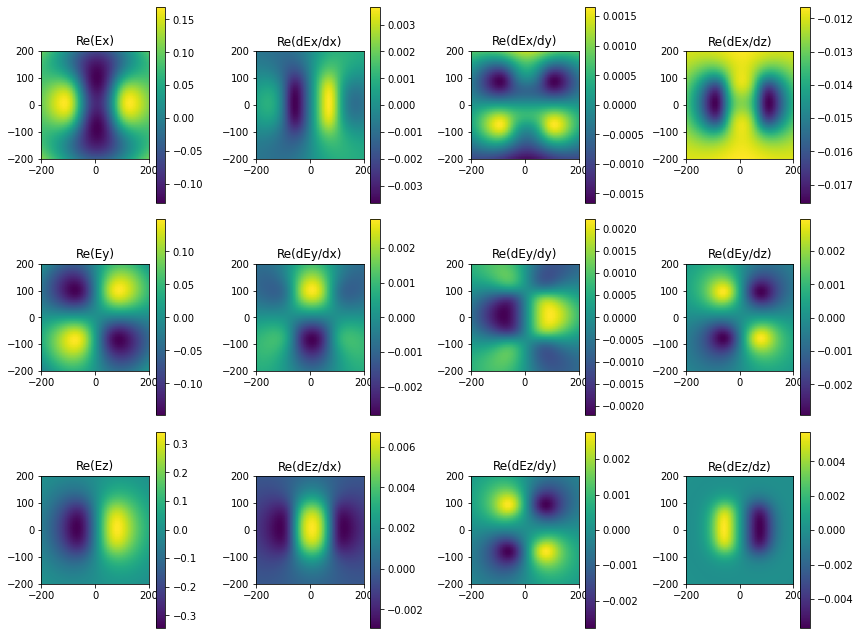

In [6]:
## --- explanation of how the plot part work :
## --- for each array dE_j (dB_j) the fieldComp represents the direction of derivation
## --- for example : fieldComp='Ex' --> dE_j/dx
## ---               fieldComp='Ey' --> dE_j/dy
## ---               fieldComp='Ez' --> dE_j/dz  with j=X,Y or Z          

cmap = 'bwr'
plt.figure(figsize=(12,9))

### -- Real part of Ex
plt.subplot(3,4,1, aspect='equal')
plt.title("Re(Ex)")
im1 = visu.vectorfield_color(_Etot, fieldComp='Ex', show=0)
plt.colorbar(im1)
### -- Real part of Ey
plt.subplot(3,4,5, aspect='equal')
plt.title("Re(Ey)")
im5 = visu.vectorfield_color(_Etot, fieldComp='Ey', show=0)
plt.colorbar(im5)
### -- Real part of Ez
plt.subplot(3,4,9, aspect='equal')
plt.title("Re(Ez)")
im9 = visu.vectorfield_color(_Etot, fieldComp='Ez', show=0)
plt.colorbar(im9)

### -- Real part of dEx/dx
plt.subplot(3,4,2, aspect='equal')
plt.title("Re(dEx/dx)")
im2 = visu.vectorfield_color(dEtdx, fieldComp='Ex', show=0)
plt.colorbar(im2)
plt.subplot(3,4,3, aspect='equal')
### -- Real part of dEx/dy
plt.title("Re(dEx/dy)")
im3 = visu.vectorfield_color(dEtdy, fieldComp='Ex', show=0)
plt.colorbar(im3)
plt.subplot(3,4,4, aspect='equal')
### -- Real part of dEx/dz
plt.title("Re(dEx/dz)")
im4 = visu.vectorfield_color(dEtdz, fieldComp='Ex', show=0)
plt.colorbar(im4)

plt.subplot(3,4,6, aspect='equal')
### -- Real part of dEy/dx
plt.title("Re(dEy/dx)")
im6 = visu.vectorfield_color(dEtdx, fieldComp='Ey', show=0)
plt.colorbar(im6)
plt.subplot(3,4,7, aspect='equal')
### -- Real part of dEy/dy
plt.title("Re(dEy/dy)")
im7 = visu.vectorfield_color(dEtdy, fieldComp='Ey', show=0)
plt.colorbar(im7)
plt.subplot(3,4,8, aspect='equal')
### -- Real part of dEy/dz
plt.title("Re(dEy/dz)")
im8 = visu.vectorfield_color(dEtdz, fieldComp='Ey', show=0)
plt.colorbar(im8)

### -- Real part of dEz/dx
plt.subplot(3,4,10, aspect='equal')
plt.title("Re(dEz/dx)")
im10 = visu.vectorfield_color(dEtdx, fieldComp='Ez', show=0)
plt.colorbar(im10)
plt.subplot(3,4,11, aspect='equal')
### -- Real part of dEz/dy
plt.title("Re(dEz/dy)")
im11 = visu.vectorfield_color(dEtdy, fieldComp='Ez', show=0)
plt.colorbar(im11)
plt.subplot(3,4,12, aspect='equal')
### -- Real part of dEz/dz
plt.title("Re(dEz/dz)")
im12 = visu.vectorfield_color(dEtdz, fieldComp='Ez', show=0)
plt.colorbar(im12)

plt.tight_layout()
plt.show()    